# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

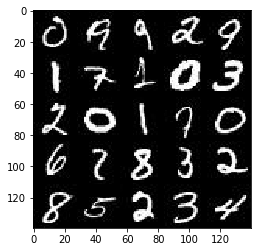

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

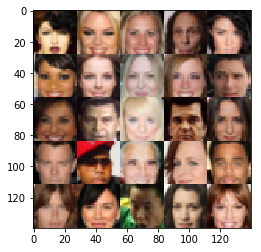

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    input_real = tf.placeholder(tf.float32, shape=(None, image_height, image_width, image_channels))
    input_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32, shape=())

    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [16]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.1
    
    with tf.variable_scope('discriminator', reuse=reuse):
        
        conv1 = tf.layers.conv2d(images, 56, 5, 2, 'SAME')
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        conv2 = tf.layers.conv2d(conv1, 112, 5, 2, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=True)
        conv2 = tf.maximum(alpha*conv2, conv2)
        
        conv3 = tf.layers.conv2d(conv2, 224, 5, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=True)
        conv3 = tf.maximum(alpha*conv3, conv3)
        
        flat   = tf.reshape(conv3, (-1, 4*4*224))
        logits = tf.layers.dense(flat, 1)
        
        logits = tf.layers.dropout(logits, rate=0.8)
        
        output = tf.sigmoid(logits)
        
    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.1
    
    with tf.variable_scope('generator', reuse=not(is_train)):
        
        # Input fully connected layer
        fully = tf.layers.dense(z, 7*7*112)
        fully = tf.reshape(fully, (-1, 7, 7, 112))
        fully = tf.layers.batch_normalization(fully, training=is_train)
        fully = tf.maximum(alpha*fully, fully)
        
        # First convolutional layer
        conv1 = tf.layers.conv2d_transpose(fully, 56, 5, 2, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha*conv1, conv1)
        
        # Output convolutional layer
        conv2 = tf.layers.conv2d_transpose(conv1, out_channel_dim, 5, 2, 'SAME')
        out = tf.tanh(conv2)

    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_real_out, d_real_logits = discriminator(input_real)
    d_fake_out, d_fake_logits = discriminator(g_model, reuse=True)
    
    smooth = 0.1
    real_labels = tf.ones_like(d_real_out) * (1 - smooth)
    fake_labels = tf.zeros_like(d_fake_out)
    g_labels    = tf.ones_like(d_fake_out)

    d_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits, labels=real_labels))
    d_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=fake_labels))
    g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits, labels=g_labels))

    d_loss = d_real_loss + d_fake_loss
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    d_updates = [opt for opt in update_ops if opt.name.startswith('discriminator')]
    g_updates = [opt for opt in update_ops if opt.name.startswith('generator')]

    with tf.control_dependencies(d_updates):
        d_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)

    with tf.control_dependencies(g_updates):
        g_opt = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
            
    return d_opt, g_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [17]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)

    steps = 0
    print_every = 10
    show_every = 100

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model

                steps += 1
                
                batch_images = batch_images*2
                
                # Get input noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z, lr: learning_rate})
            
                if steps % print_every == 0:
                    train_loss_d = d_loss.eval(feed_dict={input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval(feed_dict={input_z: batch_z})
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:
                    show_generator_output(sess, batch_size, input_z, data_shape[3], data_image_mode)
                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.3977... Generator Loss: 3.1204
Epoch 1/2... Discriminator Loss: 0.3865... Generator Loss: 3.2129
Epoch 1/2... Discriminator Loss: 0.4461... Generator Loss: 2.5968
Epoch 1/2... Discriminator Loss: 0.4222... Generator Loss: 3.6952
Epoch 1/2... Discriminator Loss: 0.4088... Generator Loss: 3.0100
Epoch 1/2... Discriminator Loss: 0.3940... Generator Loss: 4.3606
Epoch 1/2... Discriminator Loss: 0.4023... Generator Loss: 3.2720
Epoch 1/2... Discriminator Loss: 0.3821... Generator Loss: 3.4064
Epoch 1/2... Discriminator Loss: 0.4038... Generator Loss: 3.0781
Epoch 1/2... Discriminator Loss: 0.4243... Generator Loss: 3.0060


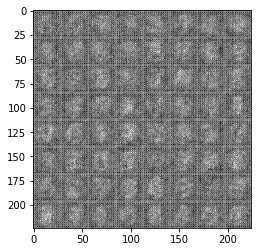

Epoch 1/2... Discriminator Loss: 0.4435... Generator Loss: 2.8985
Epoch 1/2... Discriminator Loss: 0.4627... Generator Loss: 4.7219
Epoch 1/2... Discriminator Loss: 0.4319... Generator Loss: 4.8872
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.2231
Epoch 1/2... Discriminator Loss: 0.4427... Generator Loss: 2.8321
Epoch 1/2... Discriminator Loss: 0.4135... Generator Loss: 3.2469
Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 3.2963
Epoch 1/2... Discriminator Loss: 0.4063... Generator Loss: 3.6558
Epoch 1/2... Discriminator Loss: 0.4161... Generator Loss: 3.0451
Epoch 1/2... Discriminator Loss: 0.4457... Generator Loss: 2.6602


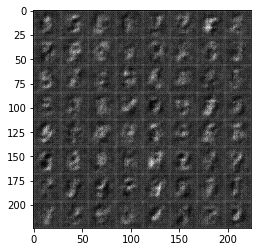

Epoch 1/2... Discriminator Loss: 0.4047... Generator Loss: 3.3642
Epoch 1/2... Discriminator Loss: 0.4407... Generator Loss: 3.4883
Epoch 1/2... Discriminator Loss: 0.4445... Generator Loss: 3.3609
Epoch 1/2... Discriminator Loss: 0.6183... Generator Loss: 2.0666
Epoch 1/2... Discriminator Loss: 0.4545... Generator Loss: 2.7230
Epoch 1/2... Discriminator Loss: 0.4776... Generator Loss: 2.2915
Epoch 1/2... Discriminator Loss: 0.4690... Generator Loss: 3.5057
Epoch 1/2... Discriminator Loss: 0.6775... Generator Loss: 1.5238
Epoch 1/2... Discriminator Loss: 0.4195... Generator Loss: 3.0674
Epoch 1/2... Discriminator Loss: 0.5245... Generator Loss: 2.0287


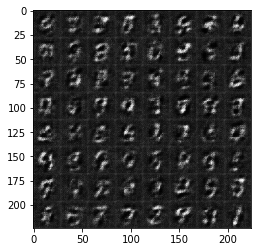

Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 2.3050
Epoch 1/2... Discriminator Loss: 0.4811... Generator Loss: 2.3666
Epoch 1/2... Discriminator Loss: 1.2339... Generator Loss: 5.3846
Epoch 1/2... Discriminator Loss: 0.4426... Generator Loss: 3.5117
Epoch 1/2... Discriminator Loss: 0.4331... Generator Loss: 3.1092
Epoch 1/2... Discriminator Loss: 0.4234... Generator Loss: 3.1129
Epoch 1/2... Discriminator Loss: 0.9713... Generator Loss: 4.8664
Epoch 1/2... Discriminator Loss: 0.4459... Generator Loss: 3.2008
Epoch 1/2... Discriminator Loss: 0.4623... Generator Loss: 2.7708
Epoch 1/2... Discriminator Loss: 0.4495... Generator Loss: 2.9676


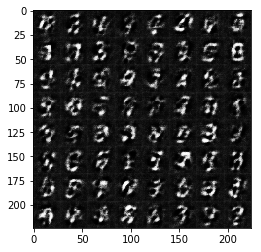

Epoch 1/2... Discriminator Loss: 0.4520... Generator Loss: 2.4847
Epoch 1/2... Discriminator Loss: 0.4677... Generator Loss: 2.6053
Epoch 1/2... Discriminator Loss: 0.4810... Generator Loss: 3.2061
Epoch 1/2... Discriminator Loss: 0.4568... Generator Loss: 3.1551
Epoch 1/2... Discriminator Loss: 0.4673... Generator Loss: 3.0516
Epoch 1/2... Discriminator Loss: 0.5083... Generator Loss: 3.7180
Epoch 1/2... Discriminator Loss: 0.4945... Generator Loss: 3.0857
Epoch 1/2... Discriminator Loss: 0.4641... Generator Loss: 2.5148
Epoch 1/2... Discriminator Loss: 0.4390... Generator Loss: 2.7337
Epoch 1/2... Discriminator Loss: 0.5609... Generator Loss: 1.9153


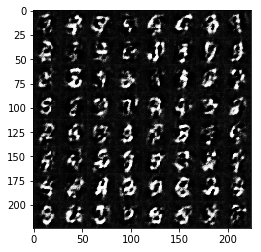

Epoch 1/2... Discriminator Loss: 0.4973... Generator Loss: 2.3286
Epoch 1/2... Discriminator Loss: 1.0287... Generator Loss: 5.2087
Epoch 1/2... Discriminator Loss: 0.5704... Generator Loss: 1.8080
Epoch 1/2... Discriminator Loss: 0.4579... Generator Loss: 2.9218
Epoch 1/2... Discriminator Loss: 0.4809... Generator Loss: 2.3567
Epoch 1/2... Discriminator Loss: 0.4605... Generator Loss: 2.7868
Epoch 1/2... Discriminator Loss: 0.4881... Generator Loss: 2.8862
Epoch 1/2... Discriminator Loss: 0.4805... Generator Loss: 2.2963
Epoch 1/2... Discriminator Loss: 0.5737... Generator Loss: 1.8453
Epoch 1/2... Discriminator Loss: 0.4488... Generator Loss: 2.7102


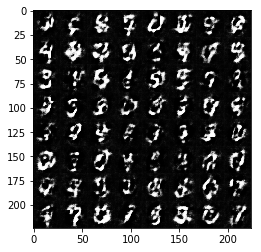

Epoch 1/2... Discriminator Loss: 0.4289... Generator Loss: 3.1763
Epoch 1/2... Discriminator Loss: 0.5072... Generator Loss: 2.2064
Epoch 1/2... Discriminator Loss: 0.4428... Generator Loss: 3.3213
Epoch 1/2... Discriminator Loss: 0.4616... Generator Loss: 2.4814
Epoch 1/2... Discriminator Loss: 0.4647... Generator Loss: 2.5157
Epoch 1/2... Discriminator Loss: 0.4708... Generator Loss: 2.5568
Epoch 1/2... Discriminator Loss: 0.4348... Generator Loss: 2.7962
Epoch 1/2... Discriminator Loss: 0.5173... Generator Loss: 2.1761
Epoch 1/2... Discriminator Loss: 0.4612... Generator Loss: 2.5320
Epoch 1/2... Discriminator Loss: 0.4114... Generator Loss: 3.4800


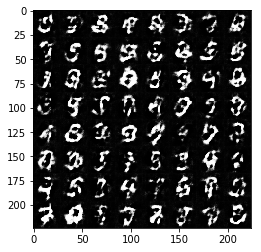

Epoch 1/2... Discriminator Loss: 0.4409... Generator Loss: 2.6469
Epoch 1/2... Discriminator Loss: 0.6166... Generator Loss: 1.6871
Epoch 1/2... Discriminator Loss: 0.4345... Generator Loss: 3.1062
Epoch 1/2... Discriminator Loss: 0.5058... Generator Loss: 2.2211
Epoch 1/2... Discriminator Loss: 0.4346... Generator Loss: 2.8527
Epoch 1/2... Discriminator Loss: 0.4823... Generator Loss: 2.8268
Epoch 1/2... Discriminator Loss: 0.4094... Generator Loss: 3.6743
Epoch 1/2... Discriminator Loss: 0.4596... Generator Loss: 2.5813
Epoch 1/2... Discriminator Loss: 1.7763... Generator Loss: 6.6225
Epoch 1/2... Discriminator Loss: 0.4646... Generator Loss: 2.9051


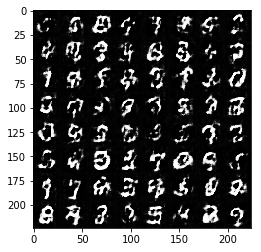

Epoch 1/2... Discriminator Loss: 0.4953... Generator Loss: 3.4988
Epoch 1/2... Discriminator Loss: 0.4361... Generator Loss: 3.1504
Epoch 1/2... Discriminator Loss: 0.4147... Generator Loss: 3.0713
Epoch 1/2... Discriminator Loss: 0.4659... Generator Loss: 2.7840
Epoch 1/2... Discriminator Loss: 0.4547... Generator Loss: 3.2737
Epoch 1/2... Discriminator Loss: 0.3937... Generator Loss: 3.3182
Epoch 1/2... Discriminator Loss: 0.4698... Generator Loss: 2.4508
Epoch 1/2... Discriminator Loss: 0.4075... Generator Loss: 3.1180
Epoch 1/2... Discriminator Loss: 0.4633... Generator Loss: 3.2891
Epoch 1/2... Discriminator Loss: 0.6301... Generator Loss: 1.6638


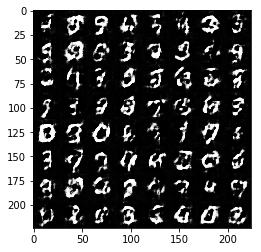

Epoch 1/2... Discriminator Loss: 0.5092... Generator Loss: 3.4274
Epoch 1/2... Discriminator Loss: 0.4207... Generator Loss: 3.2491
Epoch 1/2... Discriminator Loss: 0.4299... Generator Loss: 3.4204
Epoch 2/2... Discriminator Loss: 0.3933... Generator Loss: 3.4180
Epoch 2/2... Discriminator Loss: 0.6219... Generator Loss: 4.3870
Epoch 2/2... Discriminator Loss: 0.5413... Generator Loss: 4.2678
Epoch 2/2... Discriminator Loss: 0.4945... Generator Loss: 2.3555
Epoch 2/2... Discriminator Loss: 0.4468... Generator Loss: 2.5626
Epoch 2/2... Discriminator Loss: 0.4239... Generator Loss: 2.9536
Epoch 2/2... Discriminator Loss: 0.4195... Generator Loss: 3.1733


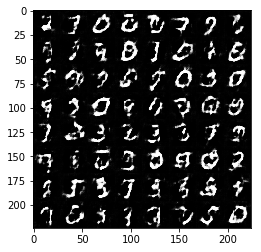

Epoch 2/2... Discriminator Loss: 0.4258... Generator Loss: 4.0460
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 2.9498
Epoch 2/2... Discriminator Loss: 0.4895... Generator Loss: 2.3781
Epoch 2/2... Discriminator Loss: 0.4445... Generator Loss: 2.7121
Epoch 2/2... Discriminator Loss: 0.4308... Generator Loss: 3.4113
Epoch 2/2... Discriminator Loss: 0.6981... Generator Loss: 4.2862
Epoch 2/2... Discriminator Loss: 0.4338... Generator Loss: 2.8446
Epoch 2/2... Discriminator Loss: 0.4324... Generator Loss: 2.8837
Epoch 2/2... Discriminator Loss: 0.4064... Generator Loss: 3.0588
Epoch 2/2... Discriminator Loss: 0.4884... Generator Loss: 2.3490


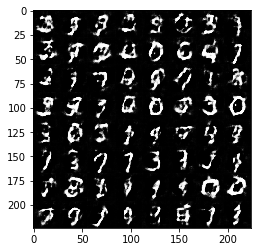

Epoch 2/2... Discriminator Loss: 0.4217... Generator Loss: 2.9878
Epoch 2/2... Discriminator Loss: 0.4181... Generator Loss: 3.2192
Epoch 2/2... Discriminator Loss: 0.4126... Generator Loss: 3.4612
Epoch 2/2... Discriminator Loss: 0.5084... Generator Loss: 2.2357
Epoch 2/2... Discriminator Loss: 0.4234... Generator Loss: 3.6389
Epoch 2/2... Discriminator Loss: 0.4748... Generator Loss: 2.3327
Epoch 2/2... Discriminator Loss: 1.4681... Generator Loss: 5.8159
Epoch 2/2... Discriminator Loss: 0.4398... Generator Loss: 2.8583
Epoch 2/2... Discriminator Loss: 0.4296... Generator Loss: 2.7532
Epoch 2/2... Discriminator Loss: 0.4772... Generator Loss: 2.4577


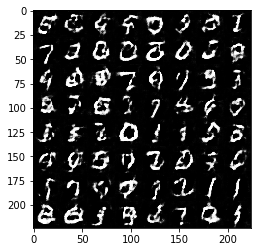

Epoch 2/2... Discriminator Loss: 0.4197... Generator Loss: 3.0608
Epoch 2/2... Discriminator Loss: 0.4327... Generator Loss: 3.0231
Epoch 2/2... Discriminator Loss: 0.4242... Generator Loss: 2.8243
Epoch 2/2... Discriminator Loss: 0.4227... Generator Loss: 3.0298
Epoch 2/2... Discriminator Loss: 0.4870... Generator Loss: 2.7912
Epoch 2/2... Discriminator Loss: 0.5675... Generator Loss: 3.6203
Epoch 2/2... Discriminator Loss: 0.5915... Generator Loss: 3.6435
Epoch 2/2... Discriminator Loss: 0.4736... Generator Loss: 3.7495
Epoch 2/2... Discriminator Loss: 0.5408... Generator Loss: 3.6557
Epoch 2/2... Discriminator Loss: 0.6720... Generator Loss: 1.5097


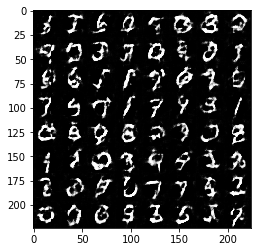

Epoch 2/2... Discriminator Loss: 0.4328... Generator Loss: 2.9370
Epoch 2/2... Discriminator Loss: 0.6025... Generator Loss: 1.7787
Epoch 2/2... Discriminator Loss: 0.4357... Generator Loss: 3.0496
Epoch 2/2... Discriminator Loss: 0.5429... Generator Loss: 2.0553
Epoch 2/2... Discriminator Loss: 0.5105... Generator Loss: 3.7428
Epoch 2/2... Discriminator Loss: 0.4893... Generator Loss: 3.3677
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 4.6649
Epoch 2/2... Discriminator Loss: 0.7299... Generator Loss: 1.4229
Epoch 2/2... Discriminator Loss: 0.4692... Generator Loss: 2.8635
Epoch 2/2... Discriminator Loss: 0.4742... Generator Loss: 3.7649


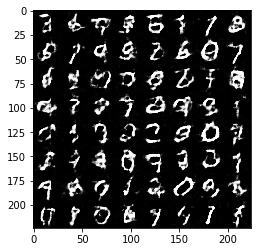

Epoch 2/2... Discriminator Loss: 0.4686... Generator Loss: 2.6576
Epoch 2/2... Discriminator Loss: 0.4580... Generator Loss: 2.5255
Epoch 2/2... Discriminator Loss: 0.7094... Generator Loss: 1.6082
Epoch 2/2... Discriminator Loss: 0.4512... Generator Loss: 2.6463
Epoch 2/2... Discriminator Loss: 0.5180... Generator Loss: 2.1736
Epoch 2/2... Discriminator Loss: 0.5598... Generator Loss: 3.9375
Epoch 2/2... Discriminator Loss: 0.4558... Generator Loss: 2.5993
Epoch 2/2... Discriminator Loss: 0.4885... Generator Loss: 2.6247
Epoch 2/2... Discriminator Loss: 0.4641... Generator Loss: 2.9734
Epoch 2/2... Discriminator Loss: 0.4665... Generator Loss: 2.8592


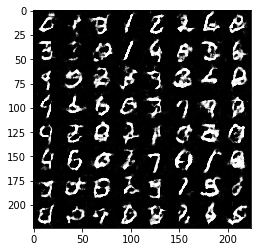

Epoch 2/2... Discriminator Loss: 0.6498... Generator Loss: 1.6423
Epoch 2/2... Discriminator Loss: 0.4522... Generator Loss: 2.5050
Epoch 2/2... Discriminator Loss: 0.4583... Generator Loss: 2.6563
Epoch 2/2... Discriminator Loss: 0.4295... Generator Loss: 2.8498
Epoch 2/2... Discriminator Loss: 0.5611... Generator Loss: 1.8843
Epoch 2/2... Discriminator Loss: 0.4944... Generator Loss: 2.2806
Epoch 2/2... Discriminator Loss: 0.5274... Generator Loss: 3.1734
Epoch 2/2... Discriminator Loss: 0.5230... Generator Loss: 2.9736
Epoch 2/2... Discriminator Loss: 0.4611... Generator Loss: 3.3871
Epoch 2/2... Discriminator Loss: 0.4925... Generator Loss: 3.0284


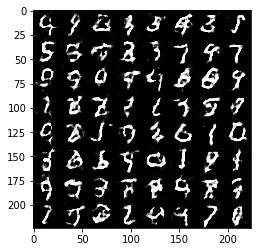

Epoch 2/2... Discriminator Loss: 0.4723... Generator Loss: 2.8146
Epoch 2/2... Discriminator Loss: 0.5019... Generator Loss: 2.2606
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 2.7237
Epoch 2/2... Discriminator Loss: 0.4466... Generator Loss: 3.2328
Epoch 2/2... Discriminator Loss: 0.4778... Generator Loss: 2.3863
Epoch 2/2... Discriminator Loss: 0.4811... Generator Loss: 2.6658
Epoch 2/2... Discriminator Loss: 0.4224... Generator Loss: 3.1284
Epoch 2/2... Discriminator Loss: 0.4557... Generator Loss: 2.8392
Epoch 2/2... Discriminator Loss: 0.4571... Generator Loss: 2.8266
Epoch 2/2... Discriminator Loss: 0.4775... Generator Loss: 2.4238


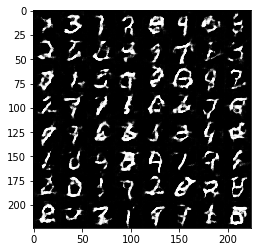

Epoch 2/2... Discriminator Loss: 0.5077... Generator Loss: 2.2256
Epoch 2/2... Discriminator Loss: 0.4447... Generator Loss: 3.1521
Epoch 2/2... Discriminator Loss: 0.4526... Generator Loss: 2.7402
Epoch 2/2... Discriminator Loss: 1.3401... Generator Loss: 5.0612
Epoch 2/2... Discriminator Loss: 0.4313... Generator Loss: 3.4341
Epoch 2/2... Discriminator Loss: 0.4876... Generator Loss: 2.6618
Epoch 2/2... Discriminator Loss: 0.4385... Generator Loss: 3.1060
Epoch 2/2... Discriminator Loss: 0.4501... Generator Loss: 2.7772
Epoch 2/2... Discriminator Loss: 0.4400... Generator Loss: 3.0489
Epoch 2/2... Discriminator Loss: 0.4407... Generator Loss: 2.9104


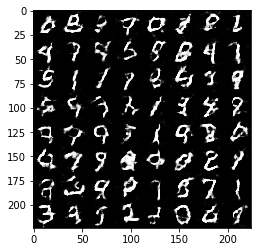

Epoch 2/2... Discriminator Loss: 0.4793... Generator Loss: 2.3832
Epoch 2/2... Discriminator Loss: 0.6595... Generator Loss: 1.6710
Epoch 2/2... Discriminator Loss: 0.4975... Generator Loss: 3.0003
Epoch 2/2... Discriminator Loss: 0.5227... Generator Loss: 2.1903
Epoch 2/2... Discriminator Loss: 0.4591... Generator Loss: 2.9024
Epoch 2/2... Discriminator Loss: 0.4347... Generator Loss: 2.9389
Epoch 2/2... Discriminator Loss: 0.4393... Generator Loss: 2.8364


In [18]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 0.5903... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 0.5430... Generator Loss: 1.9511
Epoch 1/1... Discriminator Loss: 0.4974... Generator Loss: 2.1682
Epoch 1/1... Discriminator Loss: 0.4049... Generator Loss: 3.3179
Epoch 1/1... Discriminator Loss: 0.4168... Generator Loss: 2.9166
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 1.3637
Epoch 1/1... Discriminator Loss: 0.4342... Generator Loss: 2.7209
Epoch 1/1... Discriminator Loss: 1.3265... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.4827... Generator Loss: 2.4873
Epoch 1/1... Discriminator Loss: 0.5823... Generator Loss: 3.3747


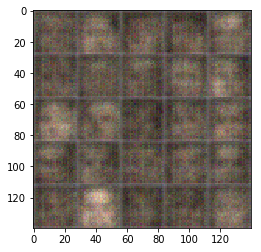

Epoch 1/1... Discriminator Loss: 0.5279... Generator Loss: 2.1432
Epoch 1/1... Discriminator Loss: 0.5504... Generator Loss: 3.1041
Epoch 1/1... Discriminator Loss: 0.9065... Generator Loss: 1.1485
Epoch 1/1... Discriminator Loss: 0.4498... Generator Loss: 2.6994
Epoch 1/1... Discriminator Loss: 0.5434... Generator Loss: 1.9854
Epoch 1/1... Discriminator Loss: 0.5808... Generator Loss: 1.7267
Epoch 1/1... Discriminator Loss: 0.6367... Generator Loss: 1.8284
Epoch 1/1... Discriminator Loss: 0.5638... Generator Loss: 1.9586
Epoch 1/1... Discriminator Loss: 1.4138... Generator Loss: 6.6306
Epoch 1/1... Discriminator Loss: 0.5127... Generator Loss: 2.2101


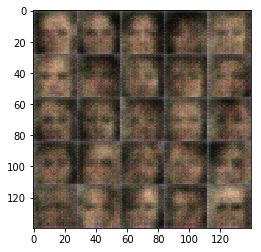

Epoch 1/1... Discriminator Loss: 2.0013... Generator Loss: 7.3506
Epoch 1/1... Discriminator Loss: 0.4591... Generator Loss: 2.5148
Epoch 1/1... Discriminator Loss: 0.7559... Generator Loss: 1.2179
Epoch 1/1... Discriminator Loss: 0.6849... Generator Loss: 2.3236
Epoch 1/1... Discriminator Loss: 2.5754... Generator Loss: 0.1977
Epoch 1/1... Discriminator Loss: 0.9603... Generator Loss: 1.0510
Epoch 1/1... Discriminator Loss: 2.2018... Generator Loss: 0.2543
Epoch 1/1... Discriminator Loss: 1.6088... Generator Loss: 3.8225
Epoch 1/1... Discriminator Loss: 0.9794... Generator Loss: 0.8361
Epoch 1/1... Discriminator Loss: 1.0781... Generator Loss: 0.8210


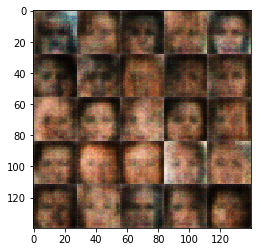

Epoch 1/1... Discriminator Loss: 0.6575... Generator Loss: 1.5262
Epoch 1/1... Discriminator Loss: 0.6453... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 0.7563... Generator Loss: 1.1772
Epoch 1/1... Discriminator Loss: 1.3660... Generator Loss: 0.5175
Epoch 1/1... Discriminator Loss: 0.6137... Generator Loss: 1.7187
Epoch 1/1... Discriminator Loss: 0.6765... Generator Loss: 1.9449
Epoch 1/1... Discriminator Loss: 1.5342... Generator Loss: 0.4507
Epoch 1/1... Discriminator Loss: 0.7627... Generator Loss: 1.3043
Epoch 1/1... Discriminator Loss: 0.6240... Generator Loss: 2.0640
Epoch 1/1... Discriminator Loss: 0.5327... Generator Loss: 1.9689


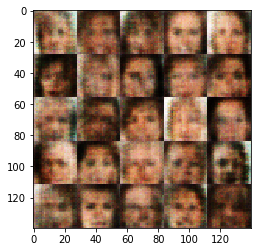

Epoch 1/1... Discriminator Loss: 0.9719... Generator Loss: 0.9134
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 2.9243
Epoch 1/1... Discriminator Loss: 2.2838... Generator Loss: 4.1381
Epoch 1/1... Discriminator Loss: 0.7420... Generator Loss: 2.2674
Epoch 1/1... Discriminator Loss: 0.6338... Generator Loss: 2.0735
Epoch 1/1... Discriminator Loss: 1.9678... Generator Loss: 0.3217
Epoch 1/1... Discriminator Loss: 0.6663... Generator Loss: 1.6070
Epoch 1/1... Discriminator Loss: 0.8170... Generator Loss: 2.1238
Epoch 1/1... Discriminator Loss: 0.8194... Generator Loss: 1.1145
Epoch 1/1... Discriminator Loss: 1.5552... Generator Loss: 0.4416


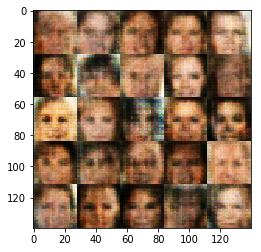

Epoch 1/1... Discriminator Loss: 0.9383... Generator Loss: 0.9257
Epoch 1/1... Discriminator Loss: 0.8209... Generator Loss: 1.8946
Epoch 1/1... Discriminator Loss: 1.2088... Generator Loss: 0.6175
Epoch 1/1... Discriminator Loss: 0.7509... Generator Loss: 2.5092
Epoch 1/1... Discriminator Loss: 0.7362... Generator Loss: 1.7123
Epoch 1/1... Discriminator Loss: 1.5896... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.0353... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.0997... Generator Loss: 2.6174
Epoch 1/1... Discriminator Loss: 1.2417... Generator Loss: 3.0776
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.7669


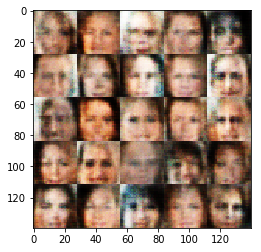

Epoch 1/1... Discriminator Loss: 0.9119... Generator Loss: 0.9945
Epoch 1/1... Discriminator Loss: 0.9454... Generator Loss: 0.9125
Epoch 1/1... Discriminator Loss: 1.3752... Generator Loss: 2.8976
Epoch 1/1... Discriminator Loss: 0.8893... Generator Loss: 1.0281
Epoch 1/1... Discriminator Loss: 1.8962... Generator Loss: 0.3264
Epoch 1/1... Discriminator Loss: 1.3112... Generator Loss: 0.5218
Epoch 1/1... Discriminator Loss: 1.2355... Generator Loss: 0.6261
Epoch 1/1... Discriminator Loss: 1.0895... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 0.7804... Generator Loss: 2.4368
Epoch 1/1... Discriminator Loss: 0.7782... Generator Loss: 2.0562


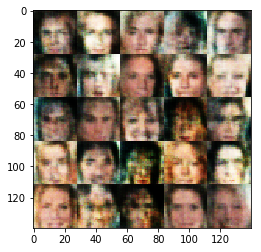

Epoch 1/1... Discriminator Loss: 1.3559... Generator Loss: 0.5119
Epoch 1/1... Discriminator Loss: 1.1490... Generator Loss: 0.7196
Epoch 1/1... Discriminator Loss: 1.0548... Generator Loss: 0.7879
Epoch 1/1... Discriminator Loss: 1.0044... Generator Loss: 0.8270
Epoch 1/1... Discriminator Loss: 0.9307... Generator Loss: 1.7712
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.5034
Epoch 1/1... Discriminator Loss: 1.1853... Generator Loss: 3.2749
Epoch 1/1... Discriminator Loss: 0.8600... Generator Loss: 1.0206
Epoch 1/1... Discriminator Loss: 0.8968... Generator Loss: 2.7380
Epoch 1/1... Discriminator Loss: 1.3154... Generator Loss: 2.6029


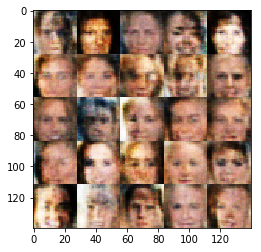

Epoch 1/1... Discriminator Loss: 0.7799... Generator Loss: 1.3784
Epoch 1/1... Discriminator Loss: 0.9154... Generator Loss: 2.3824
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.4611
Epoch 1/1... Discriminator Loss: 1.2600... Generator Loss: 0.5828
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.4819
Epoch 1/1... Discriminator Loss: 1.0266... Generator Loss: 0.7718
Epoch 1/1... Discriminator Loss: 0.9254... Generator Loss: 0.9283
Epoch 1/1... Discriminator Loss: 1.2802... Generator Loss: 2.8614
Epoch 1/1... Discriminator Loss: 0.8463... Generator Loss: 1.0415
Epoch 1/1... Discriminator Loss: 0.8611... Generator Loss: 2.5528


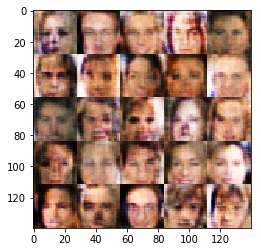

Epoch 1/1... Discriminator Loss: 1.3353... Generator Loss: 0.4928
Epoch 1/1... Discriminator Loss: 1.1572... Generator Loss: 0.6566
Epoch 1/1... Discriminator Loss: 1.4305... Generator Loss: 0.4661
Epoch 1/1... Discriminator Loss: 0.7915... Generator Loss: 1.1776
Epoch 1/1... Discriminator Loss: 0.7262... Generator Loss: 1.4738
Epoch 1/1... Discriminator Loss: 1.4288... Generator Loss: 0.5070
Epoch 1/1... Discriminator Loss: 0.7741... Generator Loss: 2.4886
Epoch 1/1... Discriminator Loss: 0.7557... Generator Loss: 1.3638
Epoch 1/1... Discriminator Loss: 0.9046... Generator Loss: 0.9374
Epoch 1/1... Discriminator Loss: 1.0170... Generator Loss: 2.4160


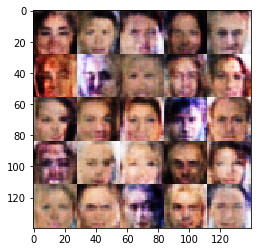

Epoch 1/1... Discriminator Loss: 1.1167... Generator Loss: 0.6963
Epoch 1/1... Discriminator Loss: 1.0011... Generator Loss: 2.6219
Epoch 1/1... Discriminator Loss: 0.8996... Generator Loss: 0.9295
Epoch 1/1... Discriminator Loss: 0.8690... Generator Loss: 1.6458
Epoch 1/1... Discriminator Loss: 0.8953... Generator Loss: 1.9941
Epoch 1/1... Discriminator Loss: 0.9698... Generator Loss: 0.8435
Epoch 1/1... Discriminator Loss: 0.8130... Generator Loss: 1.3503
Epoch 1/1... Discriminator Loss: 1.1322... Generator Loss: 0.6397
Epoch 1/1... Discriminator Loss: 0.8092... Generator Loss: 1.6929
Epoch 1/1... Discriminator Loss: 0.8808... Generator Loss: 1.1108


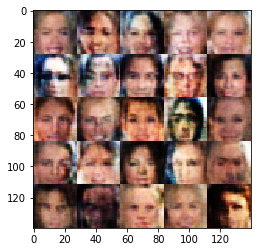

Epoch 1/1... Discriminator Loss: 0.7457... Generator Loss: 1.8988
Epoch 1/1... Discriminator Loss: 1.3415... Generator Loss: 0.4832
Epoch 1/1... Discriminator Loss: 1.2923... Generator Loss: 0.5671
Epoch 1/1... Discriminator Loss: 0.7840... Generator Loss: 1.1562
Epoch 1/1... Discriminator Loss: 0.8172... Generator Loss: 1.3524
Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 3.1782
Epoch 1/1... Discriminator Loss: 1.0519... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.0143... Generator Loss: 2.7048
Epoch 1/1... Discriminator Loss: 0.7979... Generator Loss: 1.1128
Epoch 1/1... Discriminator Loss: 1.4147... Generator Loss: 0.4779


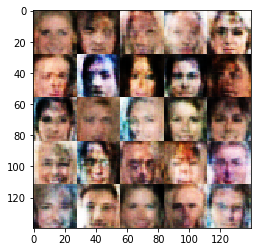

Epoch 1/1... Discriminator Loss: 0.8821... Generator Loss: 1.3726
Epoch 1/1... Discriminator Loss: 0.9489... Generator Loss: 0.9718
Epoch 1/1... Discriminator Loss: 1.1966... Generator Loss: 0.6251
Epoch 1/1... Discriminator Loss: 0.9301... Generator Loss: 3.2516
Epoch 1/1... Discriminator Loss: 0.9908... Generator Loss: 0.8550
Epoch 1/1... Discriminator Loss: 0.8712... Generator Loss: 1.0318
Epoch 1/1... Discriminator Loss: 1.1940... Generator Loss: 0.6011
Epoch 1/1... Discriminator Loss: 0.8299... Generator Loss: 1.0344
Epoch 1/1... Discriminator Loss: 0.8348... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 1.0376... Generator Loss: 0.7556


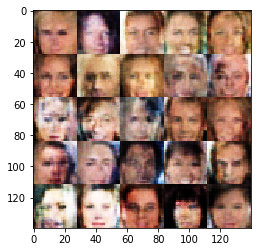

Epoch 1/1... Discriminator Loss: 1.6740... Generator Loss: 0.3803
Epoch 1/1... Discriminator Loss: 1.1526... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 0.8838... Generator Loss: 1.7490
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 0.7243... Generator Loss: 1.5121
Epoch 1/1... Discriminator Loss: 0.8510... Generator Loss: 1.4604
Epoch 1/1... Discriminator Loss: 0.9308... Generator Loss: 0.8778
Epoch 1/1... Discriminator Loss: 0.6998... Generator Loss: 1.4319
Epoch 1/1... Discriminator Loss: 1.3443... Generator Loss: 0.5156
Epoch 1/1... Discriminator Loss: 0.7645... Generator Loss: 1.2343


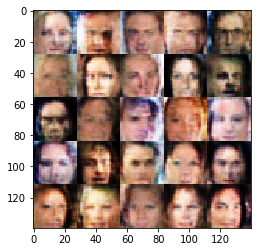

Epoch 1/1... Discriminator Loss: 1.3535... Generator Loss: 0.5460
Epoch 1/1... Discriminator Loss: 1.0355... Generator Loss: 0.7710
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.6596... Generator Loss: 0.4043
Epoch 1/1... Discriminator Loss: 0.6058... Generator Loss: 1.7274
Epoch 1/1... Discriminator Loss: 1.2811... Generator Loss: 0.5621
Epoch 1/1... Discriminator Loss: 0.7728... Generator Loss: 1.1812
Epoch 1/1... Discriminator Loss: 1.1782... Generator Loss: 0.6265
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.9112
Epoch 1/1... Discriminator Loss: 0.8798... Generator Loss: 2.7551


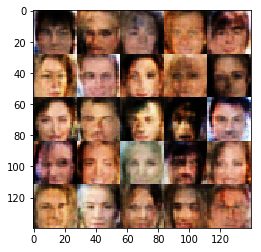

Epoch 1/1... Discriminator Loss: 0.8467... Generator Loss: 1.0595
Epoch 1/1... Discriminator Loss: 0.9946... Generator Loss: 0.7921
Epoch 1/1... Discriminator Loss: 1.4769... Generator Loss: 0.4349
Epoch 1/1... Discriminator Loss: 0.7192... Generator Loss: 1.4903
Epoch 1/1... Discriminator Loss: 0.7764... Generator Loss: 1.7559
Epoch 1/1... Discriminator Loss: 0.6797... Generator Loss: 1.7118
Epoch 1/1... Discriminator Loss: 0.7850... Generator Loss: 1.2026
Epoch 1/1... Discriminator Loss: 1.1249... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 0.7480... Generator Loss: 1.3466
Epoch 1/1... Discriminator Loss: 1.5284... Generator Loss: 0.4155


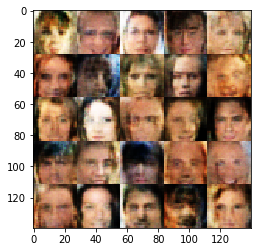

Epoch 1/1... Discriminator Loss: 1.2442... Generator Loss: 0.6086
Epoch 1/1... Discriminator Loss: 0.7770... Generator Loss: 1.1447
Epoch 1/1... Discriminator Loss: 1.4888... Generator Loss: 0.4639
Epoch 1/1... Discriminator Loss: 0.7986... Generator Loss: 1.1027
Epoch 1/1... Discriminator Loss: 0.7989... Generator Loss: 1.4733
Epoch 1/1... Discriminator Loss: 0.8775... Generator Loss: 0.9818
Epoch 1/1... Discriminator Loss: 0.5349... Generator Loss: 1.9111
Epoch 1/1... Discriminator Loss: 0.7113... Generator Loss: 1.3713
Epoch 1/1... Discriminator Loss: 1.0642... Generator Loss: 0.7123
Epoch 1/1... Discriminator Loss: 0.9296... Generator Loss: 0.8989


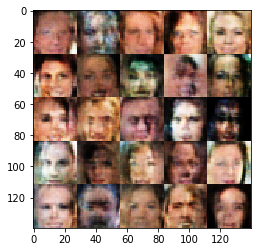

Epoch 1/1... Discriminator Loss: 1.2361... Generator Loss: 0.6123
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.7006
Epoch 1/1... Discriminator Loss: 0.6875... Generator Loss: 1.4962
Epoch 1/1... Discriminator Loss: 0.6726... Generator Loss: 1.8731
Epoch 1/1... Discriminator Loss: 1.3123... Generator Loss: 0.5085
Epoch 1/1... Discriminator Loss: 0.7808... Generator Loss: 1.3196
Epoch 1/1... Discriminator Loss: 0.8899... Generator Loss: 0.9389
Epoch 1/1... Discriminator Loss: 0.9937... Generator Loss: 3.2983
Epoch 1/1... Discriminator Loss: 0.7662... Generator Loss: 1.6408
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7152


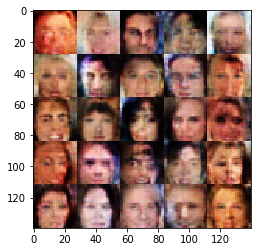

Epoch 1/1... Discriminator Loss: 1.2048... Generator Loss: 0.6030
Epoch 1/1... Discriminator Loss: 1.4596... Generator Loss: 0.4816
Epoch 1/1... Discriminator Loss: 0.7153... Generator Loss: 1.5204
Epoch 1/1... Discriminator Loss: 1.1561... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 0.7232... Generator Loss: 1.5664
Epoch 1/1... Discriminator Loss: 0.8023... Generator Loss: 1.1351
Epoch 1/1... Discriminator Loss: 1.0940... Generator Loss: 0.7216
Epoch 1/1... Discriminator Loss: 0.5217... Generator Loss: 1.9419
Epoch 1/1... Discriminator Loss: 1.6315... Generator Loss: 0.3758
Epoch 1/1... Discriminator Loss: 0.6912... Generator Loss: 1.5808


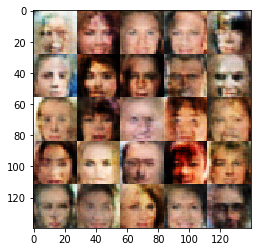

Epoch 1/1... Discriminator Loss: 0.7249... Generator Loss: 1.3378
Epoch 1/1... Discriminator Loss: 0.7389... Generator Loss: 1.8339
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.4656
Epoch 1/1... Discriminator Loss: 0.6398... Generator Loss: 1.6979
Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.4560
Epoch 1/1... Discriminator Loss: 0.7407... Generator Loss: 2.5222
Epoch 1/1... Discriminator Loss: 0.7681... Generator Loss: 1.5623
Epoch 1/1... Discriminator Loss: 0.9139... Generator Loss: 0.8838
Epoch 1/1... Discriminator Loss: 0.7160... Generator Loss: 1.2634
Epoch 1/1... Discriminator Loss: 1.7495... Generator Loss: 0.3512


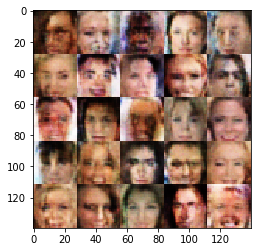

Epoch 1/1... Discriminator Loss: 0.8978... Generator Loss: 0.9942
Epoch 1/1... Discriminator Loss: 0.7908... Generator Loss: 1.1929
Epoch 1/1... Discriminator Loss: 0.8168... Generator Loss: 3.8083
Epoch 1/1... Discriminator Loss: 1.4485... Generator Loss: 0.4458
Epoch 1/1... Discriminator Loss: 0.7023... Generator Loss: 1.3679
Epoch 1/1... Discriminator Loss: 0.7314... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.2153
Epoch 1/1... Discriminator Loss: 0.7654... Generator Loss: 1.1935
Epoch 1/1... Discriminator Loss: 0.8961... Generator Loss: 1.3654
Epoch 1/1... Discriminator Loss: 0.7943... Generator Loss: 1.0641


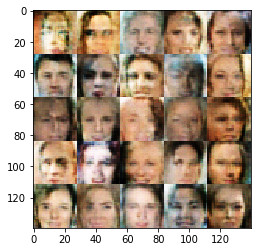

Epoch 1/1... Discriminator Loss: 1.0403... Generator Loss: 0.7582
Epoch 1/1... Discriminator Loss: 0.8174... Generator Loss: 1.1107
Epoch 1/1... Discriminator Loss: 0.8044... Generator Loss: 1.1051
Epoch 1/1... Discriminator Loss: 0.6602... Generator Loss: 1.9931
Epoch 1/1... Discriminator Loss: 0.7725... Generator Loss: 1.1520
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.6360
Epoch 1/1... Discriminator Loss: 1.1334... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 0.9234... Generator Loss: 0.9600
Epoch 1/1... Discriminator Loss: 0.9392... Generator Loss: 2.6849
Epoch 1/1... Discriminator Loss: 1.2122... Generator Loss: 0.6041


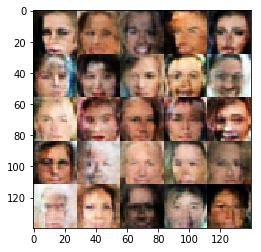

Epoch 1/1... Discriminator Loss: 1.1891... Generator Loss: 0.6016
Epoch 1/1... Discriminator Loss: 1.0635... Generator Loss: 2.2878
Epoch 1/1... Discriminator Loss: 0.9467... Generator Loss: 0.8859
Epoch 1/1... Discriminator Loss: 0.8766... Generator Loss: 0.9691
Epoch 1/1... Discriminator Loss: 0.6526... Generator Loss: 1.8273
Epoch 1/1... Discriminator Loss: 1.1519... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.8047... Generator Loss: 1.7788
Epoch 1/1... Discriminator Loss: 0.8400... Generator Loss: 1.0270
Epoch 1/1... Discriminator Loss: 1.7992... Generator Loss: 0.3683
Epoch 1/1... Discriminator Loss: 0.6871... Generator Loss: 1.5257


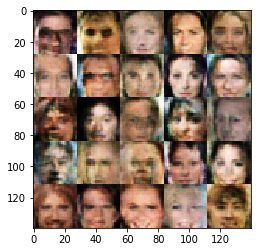

Epoch 1/1... Discriminator Loss: 0.8127... Generator Loss: 1.2796
Epoch 1/1... Discriminator Loss: 0.8844... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 0.7335... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 0.8246... Generator Loss: 1.0541
Epoch 1/1... Discriminator Loss: 0.9221... Generator Loss: 0.9357
Epoch 1/1... Discriminator Loss: 0.6378... Generator Loss: 1.4786
Epoch 1/1... Discriminator Loss: 1.2399... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.3111... Generator Loss: 0.5342
Epoch 1/1... Discriminator Loss: 0.8084... Generator Loss: 1.1600
Epoch 1/1... Discriminator Loss: 0.6072... Generator Loss: 2.4205


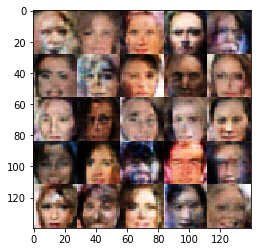

Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5335
Epoch 1/1... Discriminator Loss: 0.7644... Generator Loss: 1.2692
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7983
Epoch 1/1... Discriminator Loss: 1.2772... Generator Loss: 0.5417
Epoch 1/1... Discriminator Loss: 1.6598... Generator Loss: 3.6486
Epoch 1/1... Discriminator Loss: 1.0915... Generator Loss: 0.7206
Epoch 1/1... Discriminator Loss: 1.2349... Generator Loss: 0.5772
Epoch 1/1... Discriminator Loss: 1.0016... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.2286... Generator Loss: 0.6708
Epoch 1/1... Discriminator Loss: 1.3837... Generator Loss: 2.9879


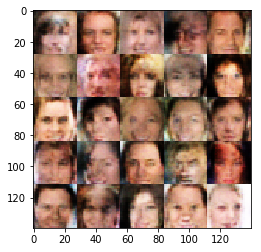

Epoch 1/1... Discriminator Loss: 1.1482... Generator Loss: 3.3730
Epoch 1/1... Discriminator Loss: 0.6915... Generator Loss: 1.4555
Epoch 1/1... Discriminator Loss: 0.8455... Generator Loss: 1.0115
Epoch 1/1... Discriminator Loss: 0.7747... Generator Loss: 1.3675
Epoch 1/1... Discriminator Loss: 1.2948... Generator Loss: 0.5397
Epoch 1/1... Discriminator Loss: 0.9375... Generator Loss: 0.9489
Epoch 1/1... Discriminator Loss: 0.7453... Generator Loss: 1.2693
Epoch 1/1... Discriminator Loss: 0.8131... Generator Loss: 1.9927
Epoch 1/1... Discriminator Loss: 0.8188... Generator Loss: 1.4405
Epoch 1/1... Discriminator Loss: 0.7594... Generator Loss: 1.3738


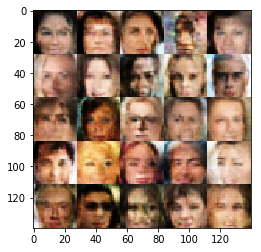

Epoch 1/1... Discriminator Loss: 0.7947... Generator Loss: 1.0984
Epoch 1/1... Discriminator Loss: 0.7901... Generator Loss: 1.4050
Epoch 1/1... Discriminator Loss: 0.9277... Generator Loss: 0.9039
Epoch 1/1... Discriminator Loss: 0.9524... Generator Loss: 2.8997
Epoch 1/1... Discriminator Loss: 0.9224... Generator Loss: 0.8699
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.6701
Epoch 1/1... Discriminator Loss: 0.5785... Generator Loss: 1.7318
Epoch 1/1... Discriminator Loss: 0.9017... Generator Loss: 1.0138
Epoch 1/1... Discriminator Loss: 0.7170... Generator Loss: 1.3779
Epoch 1/1... Discriminator Loss: 1.1202... Generator Loss: 0.6529


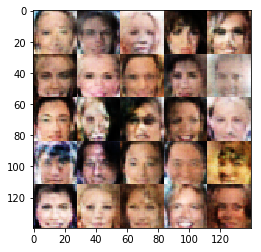

Epoch 1/1... Discriminator Loss: 0.7560... Generator Loss: 1.6902
Epoch 1/1... Discriminator Loss: 1.0716... Generator Loss: 0.7512
Epoch 1/1... Discriminator Loss: 0.7410... Generator Loss: 1.2416
Epoch 1/1... Discriminator Loss: 0.8343... Generator Loss: 2.2395
Epoch 1/1... Discriminator Loss: 1.1149... Generator Loss: 0.7129
Epoch 1/1... Discriminator Loss: 0.7173... Generator Loss: 1.2451
Epoch 1/1... Discriminator Loss: 0.8940... Generator Loss: 0.9880
Epoch 1/1... Discriminator Loss: 1.0290... Generator Loss: 0.7629
Epoch 1/1... Discriminator Loss: 0.7486... Generator Loss: 1.8525
Epoch 1/1... Discriminator Loss: 0.8666... Generator Loss: 1.0323


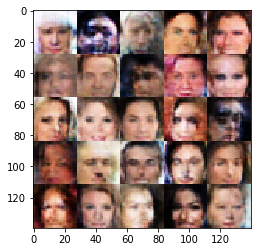

Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.4150
Epoch 1/1... Discriminator Loss: 1.2784... Generator Loss: 0.5651
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.4585
Epoch 1/1... Discriminator Loss: 1.1655... Generator Loss: 0.6585
Epoch 1/1... Discriminator Loss: 0.7685... Generator Loss: 1.1483
Epoch 1/1... Discriminator Loss: 0.7395... Generator Loss: 1.2625
Epoch 1/1... Discriminator Loss: 0.5568... Generator Loss: 1.7841
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.5683
Epoch 1/1... Discriminator Loss: 0.7692... Generator Loss: 1.1873
Epoch 1/1... Discriminator Loss: 0.8266... Generator Loss: 1.0596


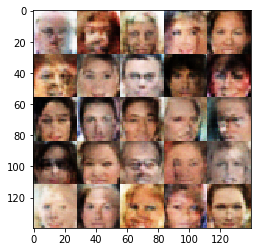

Epoch 1/1... Discriminator Loss: 0.7250... Generator Loss: 1.4139
Epoch 1/1... Discriminator Loss: 1.6321... Generator Loss: 0.4093
Epoch 1/1... Discriminator Loss: 1.2867... Generator Loss: 0.6068
Epoch 1/1... Discriminator Loss: 0.9263... Generator Loss: 0.9505
Epoch 1/1... Discriminator Loss: 0.8149... Generator Loss: 1.0561
Epoch 1/1... Discriminator Loss: 1.1059... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.7100... Generator Loss: 0.3745
Epoch 1/1... Discriminator Loss: 0.7441... Generator Loss: 1.2405
Epoch 1/1... Discriminator Loss: 1.1725... Generator Loss: 0.6730
Epoch 1/1... Discriminator Loss: 0.8163... Generator Loss: 1.2154


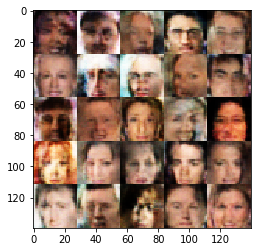

Epoch 1/1... Discriminator Loss: 0.7224... Generator Loss: 2.8119
Epoch 1/1... Discriminator Loss: 1.1665... Generator Loss: 0.6278
Epoch 1/1... Discriminator Loss: 0.8419... Generator Loss: 1.0139
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6169
Epoch 1/1... Discriminator Loss: 0.7172... Generator Loss: 1.7059
Epoch 1/1... Discriminator Loss: 0.7136... Generator Loss: 1.6694
Epoch 1/1... Discriminator Loss: 0.8558... Generator Loss: 1.0877
Epoch 1/1... Discriminator Loss: 1.3893... Generator Loss: 0.5604
Epoch 1/1... Discriminator Loss: 0.8646... Generator Loss: 1.1787
Epoch 1/1... Discriminator Loss: 1.5005... Generator Loss: 0.4890


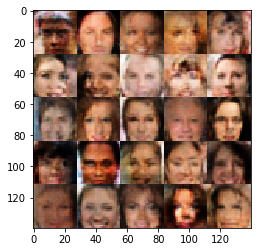

Epoch 1/1... Discriminator Loss: 0.7794... Generator Loss: 1.8438
Epoch 1/1... Discriminator Loss: 1.6260... Generator Loss: 0.3832
Epoch 1/1... Discriminator Loss: 0.7496... Generator Loss: 1.6352
Epoch 1/1... Discriminator Loss: 0.9495... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 0.7437... Generator Loss: 1.2644
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.4682
Epoch 1/1... Discriminator Loss: 0.7792... Generator Loss: 1.1310
Epoch 1/1... Discriminator Loss: 0.8175... Generator Loss: 1.1845
Epoch 1/1... Discriminator Loss: 0.7175... Generator Loss: 1.3910
Epoch 1/1... Discriminator Loss: 1.0361... Generator Loss: 0.7728


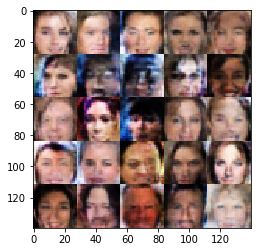

Epoch 1/1... Discriminator Loss: 0.6549... Generator Loss: 1.5727
Epoch 1/1... Discriminator Loss: 0.7155... Generator Loss: 1.9783
Epoch 1/1... Discriminator Loss: 2.3376... Generator Loss: 0.1787
Epoch 1/1... Discriminator Loss: 1.5680... Generator Loss: 0.4223
Epoch 1/1... Discriminator Loss: 2.1054... Generator Loss: 0.2798
Epoch 1/1... Discriminator Loss: 1.3960... Generator Loss: 0.4925
Epoch 1/1... Discriminator Loss: 0.7137... Generator Loss: 1.2659
Epoch 1/1... Discriminator Loss: 0.7775... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 0.8451... Generator Loss: 1.1795
Epoch 1/1... Discriminator Loss: 0.6809... Generator Loss: 1.5463


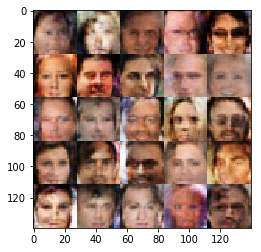

Epoch 1/1... Discriminator Loss: 0.8665... Generator Loss: 1.1705
Epoch 1/1... Discriminator Loss: 0.5779... Generator Loss: 1.7688
Epoch 1/1... Discriminator Loss: 0.7866... Generator Loss: 1.2590
Epoch 1/1... Discriminator Loss: 0.5971... Generator Loss: 1.6610
Epoch 1/1... Discriminator Loss: 0.7566... Generator Loss: 1.2725
Epoch 1/1... Discriminator Loss: 0.6561... Generator Loss: 2.0534
Epoch 1/1... Discriminator Loss: 0.9426... Generator Loss: 0.8660
Epoch 1/1... Discriminator Loss: 0.7149... Generator Loss: 1.4353
Epoch 1/1... Discriminator Loss: 0.6607... Generator Loss: 1.6655
Epoch 1/1... Discriminator Loss: 0.6123... Generator Loss: 1.6724


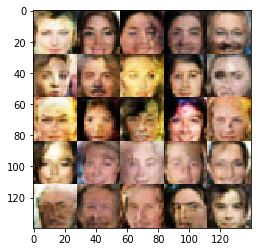

Epoch 1/1... Discriminator Loss: 0.5741... Generator Loss: 1.7741
Epoch 1/1... Discriminator Loss: 1.8715... Generator Loss: 3.6314
Epoch 1/1... Discriminator Loss: 1.4740... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 0.8733... Generator Loss: 0.9569
Epoch 1/1... Discriminator Loss: 1.3104... Generator Loss: 0.5678
Epoch 1/1... Discriminator Loss: 0.6701... Generator Loss: 1.5282
Epoch 1/1... Discriminator Loss: 1.1533... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 0.6762... Generator Loss: 1.4113
Epoch 1/1... Discriminator Loss: 0.8439... Generator Loss: 1.1736
Epoch 1/1... Discriminator Loss: 0.8896... Generator Loss: 2.1609


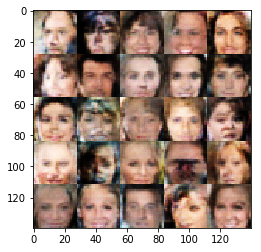

Epoch 1/1... Discriminator Loss: 0.7345... Generator Loss: 1.2168
Epoch 1/1... Discriminator Loss: 0.7859... Generator Loss: 1.4088
Epoch 1/1... Discriminator Loss: 0.6785... Generator Loss: 1.6792
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.0212
Epoch 1/1... Discriminator Loss: 0.6519... Generator Loss: 2.0191
Epoch 1/1... Discriminator Loss: 0.5981... Generator Loss: 1.9660
Epoch 1/1... Discriminator Loss: 1.3467... Generator Loss: 0.5346
Epoch 1/1... Discriminator Loss: 1.0094... Generator Loss: 0.7773
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.4580
Epoch 1/1... Discriminator Loss: 1.1956... Generator Loss: 0.6040


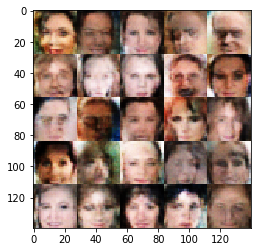

Epoch 1/1... Discriminator Loss: 0.7340... Generator Loss: 1.9080
Epoch 1/1... Discriminator Loss: 0.6976... Generator Loss: 1.7951
Epoch 1/1... Discriminator Loss: 0.8240... Generator Loss: 1.1733
Epoch 1/1... Discriminator Loss: 0.6131... Generator Loss: 1.5624
Epoch 1/1... Discriminator Loss: 1.2852... Generator Loss: 0.5625
Epoch 1/1... Discriminator Loss: 1.4073... Generator Loss: 0.4780
Epoch 1/1... Discriminator Loss: 1.2708... Generator Loss: 0.5549
Epoch 1/1... Discriminator Loss: 0.7366... Generator Loss: 1.3137
Epoch 1/1... Discriminator Loss: 0.7905... Generator Loss: 1.1627
Epoch 1/1... Discriminator Loss: 1.0754... Generator Loss: 0.7128


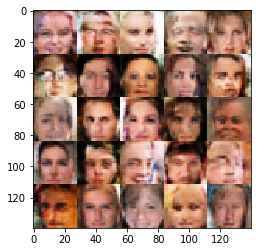

Epoch 1/1... Discriminator Loss: 0.6590... Generator Loss: 1.4077
Epoch 1/1... Discriminator Loss: 1.5486... Generator Loss: 0.4034
Epoch 1/1... Discriminator Loss: 0.9768... Generator Loss: 0.8440
Epoch 1/1... Discriminator Loss: 1.4688... Generator Loss: 0.5137
Epoch 1/1... Discriminator Loss: 0.6999... Generator Loss: 1.4078
Epoch 1/1... Discriminator Loss: 1.4166... Generator Loss: 0.4899
Epoch 1/1... Discriminator Loss: 0.7561... Generator Loss: 1.2046
Epoch 1/1... Discriminator Loss: 0.6868... Generator Loss: 1.4317
Epoch 1/1... Discriminator Loss: 1.2212... Generator Loss: 0.6187
Epoch 1/1... Discriminator Loss: 0.9264... Generator Loss: 0.8997


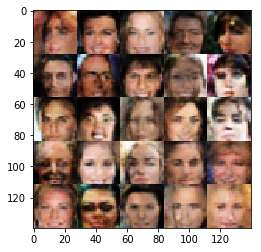

Epoch 1/1... Discriminator Loss: 0.8281... Generator Loss: 1.0352
Epoch 1/1... Discriminator Loss: 1.0855... Generator Loss: 0.7078
Epoch 1/1... Discriminator Loss: 1.9856... Generator Loss: 4.4793
Epoch 1/1... Discriminator Loss: 0.7519... Generator Loss: 1.6860
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 2.2698
Epoch 1/1... Discriminator Loss: 1.3537... Generator Loss: 0.5192
Epoch 1/1... Discriminator Loss: 0.8028... Generator Loss: 1.9922
Epoch 1/1... Discriminator Loss: 0.6810... Generator Loss: 1.9070
Epoch 1/1... Discriminator Loss: 0.6843... Generator Loss: 1.3656
Epoch 1/1... Discriminator Loss: 1.3428... Generator Loss: 0.5482


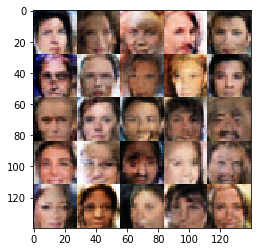

Epoch 1/1... Discriminator Loss: 1.0513... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 0.9892... Generator Loss: 0.8500
Epoch 1/1... Discriminator Loss: 0.9278... Generator Loss: 0.8714
Epoch 1/1... Discriminator Loss: 0.9245... Generator Loss: 0.8852
Epoch 1/1... Discriminator Loss: 0.9545... Generator Loss: 0.9011
Epoch 1/1... Discriminator Loss: 0.8128... Generator Loss: 1.2542
Epoch 1/1... Discriminator Loss: 0.9385... Generator Loss: 0.8499
Epoch 1/1... Discriminator Loss: 1.3695... Generator Loss: 2.9008
Epoch 1/1... Discriminator Loss: 0.7378... Generator Loss: 1.3983
Epoch 1/1... Discriminator Loss: 0.6206... Generator Loss: 1.7090


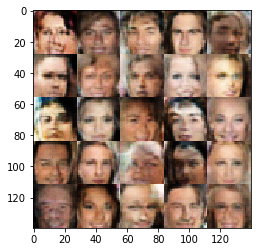

Epoch 1/1... Discriminator Loss: 1.2696... Generator Loss: 0.5669
Epoch 1/1... Discriminator Loss: 0.8851... Generator Loss: 0.9770
Epoch 1/1... Discriminator Loss: 0.9627... Generator Loss: 0.8108
Epoch 1/1... Discriminator Loss: 1.1126... Generator Loss: 0.7302
Epoch 1/1... Discriminator Loss: 0.9093... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.2438... Generator Loss: 0.5725
Epoch 1/1... Discriminator Loss: 1.2398... Generator Loss: 0.6553
Epoch 1/1... Discriminator Loss: 0.5243... Generator Loss: 2.0471
Epoch 1/1... Discriminator Loss: 0.6603... Generator Loss: 2.1553
Epoch 1/1... Discriminator Loss: 0.6665... Generator Loss: 1.6925


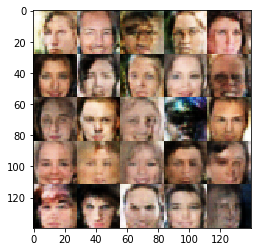

Epoch 1/1... Discriminator Loss: 0.9043... Generator Loss: 0.9246
Epoch 1/1... Discriminator Loss: 0.9216... Generator Loss: 0.8721
Epoch 1/1... Discriminator Loss: 0.6634... Generator Loss: 1.5088
Epoch 1/1... Discriminator Loss: 0.8326... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 0.7925... Generator Loss: 1.9176
Epoch 1/1... Discriminator Loss: 1.7394... Generator Loss: 0.3120
Epoch 1/1... Discriminator Loss: 0.6186... Generator Loss: 2.0704
Epoch 1/1... Discriminator Loss: 0.7000... Generator Loss: 1.5888
Epoch 1/1... Discriminator Loss: 1.1990... Generator Loss: 2.6409
Epoch 1/1... Discriminator Loss: 0.8132... Generator Loss: 1.1041


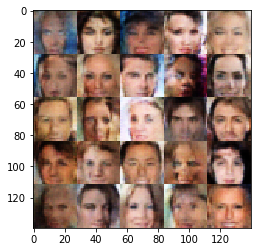

Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 0.8208... Generator Loss: 1.2193
Epoch 1/1... Discriminator Loss: 1.0713... Generator Loss: 2.4328
Epoch 1/1... Discriminator Loss: 0.8082... Generator Loss: 2.1012
Epoch 1/1... Discriminator Loss: 0.7520... Generator Loss: 1.2011
Epoch 1/1... Discriminator Loss: 0.5145... Generator Loss: 1.9593
Epoch 1/1... Discriminator Loss: 0.8351... Generator Loss: 1.0820
Epoch 1/1... Discriminator Loss: 1.1969... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 1.6820... Generator Loss: 0.3710
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 0.7580


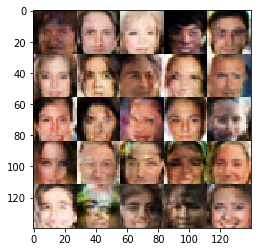

Epoch 1/1... Discriminator Loss: 1.0099... Generator Loss: 0.8004
Epoch 1/1... Discriminator Loss: 1.0509... Generator Loss: 0.7862
Epoch 1/1... Discriminator Loss: 0.9376... Generator Loss: 0.9036
Epoch 1/1... Discriminator Loss: 0.7615... Generator Loss: 1.1936
Epoch 1/1... Discriminator Loss: 0.7354... Generator Loss: 1.3443
Epoch 1/1... Discriminator Loss: 0.9729... Generator Loss: 2.0994
Epoch 1/1... Discriminator Loss: 0.7923... Generator Loss: 1.6886
Epoch 1/1... Discriminator Loss: 1.0221... Generator Loss: 2.4316
Epoch 1/1... Discriminator Loss: 0.5818... Generator Loss: 1.7040
Epoch 1/1... Discriminator Loss: 0.7970... Generator Loss: 2.7670


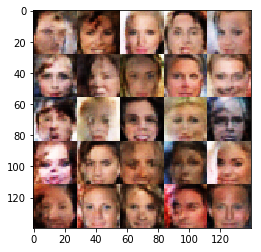

Epoch 1/1... Discriminator Loss: 1.0769... Generator Loss: 0.7278
Epoch 1/1... Discriminator Loss: 1.1903... Generator Loss: 0.6273
Epoch 1/1... Discriminator Loss: 0.9210... Generator Loss: 2.3578
Epoch 1/1... Discriminator Loss: 0.6311... Generator Loss: 1.5058
Epoch 1/1... Discriminator Loss: 1.2114... Generator Loss: 0.5871
Epoch 1/1... Discriminator Loss: 1.1293... Generator Loss: 2.7916
Epoch 1/1... Discriminator Loss: 1.3196... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.8870... Generator Loss: 3.1693
Epoch 1/1... Discriminator Loss: 0.7954... Generator Loss: 2.2694
Epoch 1/1... Discriminator Loss: 0.7123... Generator Loss: 1.2709


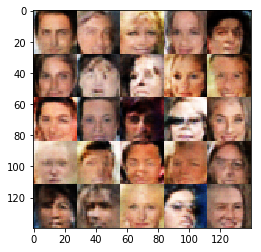

Epoch 1/1... Discriminator Loss: 0.7367... Generator Loss: 1.2433
Epoch 1/1... Discriminator Loss: 0.9004... Generator Loss: 1.0459
Epoch 1/1... Discriminator Loss: 0.6640... Generator Loss: 1.4074
Epoch 1/1... Discriminator Loss: 0.7817... Generator Loss: 2.4978
Epoch 1/1... Discriminator Loss: 0.9365... Generator Loss: 0.8866
Epoch 1/1... Discriminator Loss: 0.6805... Generator Loss: 1.6431
Epoch 1/1... Discriminator Loss: 0.7445... Generator Loss: 1.6341
Epoch 1/1... Discriminator Loss: 1.1135... Generator Loss: 0.6889
Epoch 1/1... Discriminator Loss: 0.8668... Generator Loss: 1.0253
Epoch 1/1... Discriminator Loss: 1.6913... Generator Loss: 0.3661


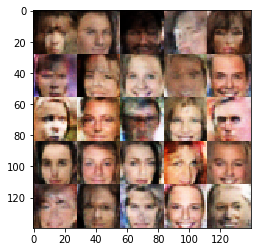

Epoch 1/1... Discriminator Loss: 0.8760... Generator Loss: 2.2011
Epoch 1/1... Discriminator Loss: 1.0146... Generator Loss: 0.9086
Epoch 1/1... Discriminator Loss: 0.7935... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 0.9380... Generator Loss: 0.8577
Epoch 1/1... Discriminator Loss: 0.8495... Generator Loss: 0.9982
Epoch 1/1... Discriminator Loss: 1.4498... Generator Loss: 0.4842
Epoch 1/1... Discriminator Loss: 0.5790... Generator Loss: 1.7524
Epoch 1/1... Discriminator Loss: 1.6420... Generator Loss: 0.3599
Epoch 1/1... Discriminator Loss: 0.9274... Generator Loss: 0.8600
Epoch 1/1... Discriminator Loss: 1.2142... Generator Loss: 0.5994


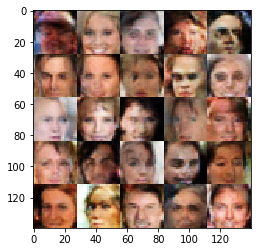

Epoch 1/1... Discriminator Loss: 2.2892... Generator Loss: 0.2099
Epoch 1/1... Discriminator Loss: 0.8203... Generator Loss: 1.0764
Epoch 1/1... Discriminator Loss: 0.8928... Generator Loss: 1.7519
Epoch 1/1... Discriminator Loss: 0.9556... Generator Loss: 1.0086
Epoch 1/1... Discriminator Loss: 0.8404... Generator Loss: 1.0734
Epoch 1/1... Discriminator Loss: 1.0446... Generator Loss: 0.7396
Epoch 1/1... Discriminator Loss: 0.8935... Generator Loss: 1.0133
Epoch 1/1... Discriminator Loss: 0.8501... Generator Loss: 1.9230
Epoch 1/1... Discriminator Loss: 0.7763... Generator Loss: 1.2488
Epoch 1/1... Discriminator Loss: 0.9481... Generator Loss: 0.9251


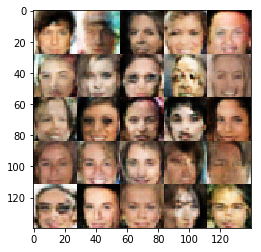

Epoch 1/1... Discriminator Loss: 0.7185... Generator Loss: 1.5077
Epoch 1/1... Discriminator Loss: 1.3458... Generator Loss: 0.4946
Epoch 1/1... Discriminator Loss: 0.8515... Generator Loss: 1.0875
Epoch 1/1... Discriminator Loss: 0.5447... Generator Loss: 1.8932
Epoch 1/1... Discriminator Loss: 1.1400... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.1838... Generator Loss: 0.6236
Epoch 1/1... Discriminator Loss: 0.9290... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2408... Generator Loss: 3.0810
Epoch 1/1... Discriminator Loss: 1.9801... Generator Loss: 0.3145
Epoch 1/1... Discriminator Loss: 1.6547... Generator Loss: 0.3872


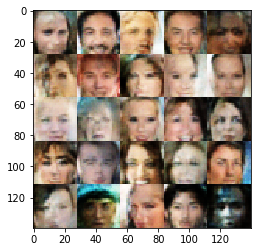

Epoch 1/1... Discriminator Loss: 0.8742... Generator Loss: 0.9478
Epoch 1/1... Discriminator Loss: 1.1815... Generator Loss: 0.6456
Epoch 1/1... Discriminator Loss: 1.0326... Generator Loss: 0.7932
Epoch 1/1... Discriminator Loss: 0.7694... Generator Loss: 1.3586
Epoch 1/1... Discriminator Loss: 1.1772... Generator Loss: 0.6684
Epoch 1/1... Discriminator Loss: 0.7263... Generator Loss: 1.2330
Epoch 1/1... Discriminator Loss: 1.2410... Generator Loss: 0.6257
Epoch 1/1... Discriminator Loss: 1.2344... Generator Loss: 0.6461
Epoch 1/1... Discriminator Loss: 0.9971... Generator Loss: 0.8424
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.7132


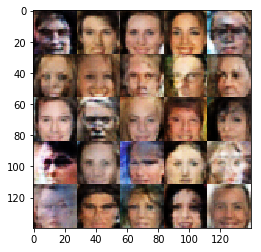

Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.4654
Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 0.7823
Epoch 1/1... Discriminator Loss: 0.5711... Generator Loss: 1.6675
Epoch 1/1... Discriminator Loss: 0.7573... Generator Loss: 1.3028
Epoch 1/1... Discriminator Loss: 0.6167... Generator Loss: 2.0581
Epoch 1/1... Discriminator Loss: 0.8942... Generator Loss: 0.9730
Epoch 1/1... Discriminator Loss: 1.1153... Generator Loss: 0.8938
Epoch 1/1... Discriminator Loss: 0.7830... Generator Loss: 1.1710
Epoch 1/1... Discriminator Loss: 1.1295... Generator Loss: 0.6696
Epoch 1/1... Discriminator Loss: 1.1044... Generator Loss: 0.6890


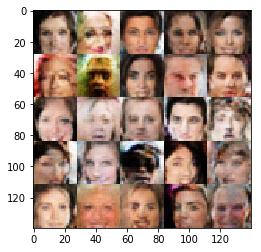

Epoch 1/1... Discriminator Loss: 0.7154... Generator Loss: 1.7772
Epoch 1/1... Discriminator Loss: 0.7602... Generator Loss: 1.2535
Epoch 1/1... Discriminator Loss: 0.9288... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.4463... Generator Loss: 0.4601
Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.6362
Epoch 1/1... Discriminator Loss: 0.7802... Generator Loss: 1.7390
Epoch 1/1... Discriminator Loss: 0.8331... Generator Loss: 1.0240
Epoch 1/1... Discriminator Loss: 0.8499... Generator Loss: 1.1505
Epoch 1/1... Discriminator Loss: 1.1843... Generator Loss: 0.6685
Epoch 1/1... Discriminator Loss: 0.7401... Generator Loss: 2.7819


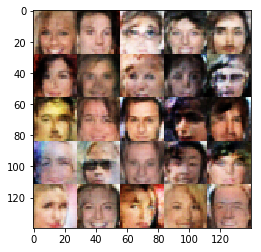

Epoch 1/1... Discriminator Loss: 1.2886... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 0.7917... Generator Loss: 1.4456
Epoch 1/1... Discriminator Loss: 1.0436... Generator Loss: 0.7535
Epoch 1/1... Discriminator Loss: 1.1074... Generator Loss: 0.6794
Epoch 1/1... Discriminator Loss: 1.7929... Generator Loss: 0.3232
Epoch 1/1... Discriminator Loss: 1.1003... Generator Loss: 0.7300
Epoch 1/1... Discriminator Loss: 0.8201... Generator Loss: 1.0871
Epoch 1/1... Discriminator Loss: 0.9477... Generator Loss: 2.5341
Epoch 1/1... Discriminator Loss: 0.8589... Generator Loss: 1.0251
Epoch 1/1... Discriminator Loss: 1.3710... Generator Loss: 0.5911


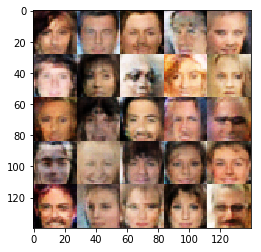

Epoch 1/1... Discriminator Loss: 0.6764... Generator Loss: 1.4189
Epoch 1/1... Discriminator Loss: 0.8062... Generator Loss: 1.1311
Epoch 1/1... Discriminator Loss: 0.9551... Generator Loss: 0.8427
Epoch 1/1... Discriminator Loss: 0.8043... Generator Loss: 1.0633
Epoch 1/1... Discriminator Loss: 1.7792... Generator Loss: 0.3811
Epoch 1/1... Discriminator Loss: 0.9531... Generator Loss: 0.9189
Epoch 1/1... Discriminator Loss: 0.7133... Generator Loss: 2.0159
Epoch 1/1... Discriminator Loss: 0.9269... Generator Loss: 0.9220
Epoch 1/1... Discriminator Loss: 0.6928... Generator Loss: 1.4820
Epoch 1/1... Discriminator Loss: 0.9220... Generator Loss: 0.9731


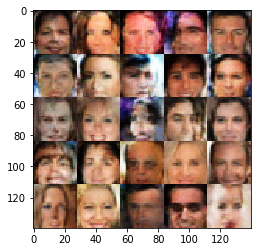

Epoch 1/1... Discriminator Loss: 1.0012... Generator Loss: 0.8101
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 0.7881
Epoch 1/1... Discriminator Loss: 0.7907... Generator Loss: 1.1564
Epoch 1/1... Discriminator Loss: 0.5820... Generator Loss: 2.5041
Epoch 1/1... Discriminator Loss: 0.9839... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 0.8164... Generator Loss: 1.1170
Epoch 1/1... Discriminator Loss: 2.0247... Generator Loss: 0.2545
Epoch 1/1... Discriminator Loss: 1.1970... Generator Loss: 0.6219
Epoch 1/1... Discriminator Loss: 0.8202... Generator Loss: 1.0876
Epoch 1/1... Discriminator Loss: 0.8074... Generator Loss: 1.1705


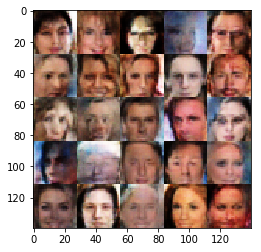

Epoch 1/1... Discriminator Loss: 0.6390... Generator Loss: 1.6161
Epoch 1/1... Discriminator Loss: 0.9576... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.1524... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 0.7869... Generator Loss: 1.1166
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 2.0541
Epoch 1/1... Discriminator Loss: 0.6287... Generator Loss: 1.6827
Epoch 1/1... Discriminator Loss: 0.6613... Generator Loss: 1.4918
Epoch 1/1... Discriminator Loss: 0.7011... Generator Loss: 1.2991
Epoch 1/1... Discriminator Loss: 0.6827... Generator Loss: 1.6126
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 0.7950


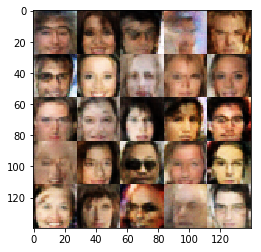

Epoch 1/1... Discriminator Loss: 1.3522... Generator Loss: 2.4356
Epoch 1/1... Discriminator Loss: 1.2200... Generator Loss: 0.6022
Epoch 1/1... Discriminator Loss: 0.6955... Generator Loss: 1.3732
Epoch 1/1... Discriminator Loss: 1.6744... Generator Loss: 0.3649
Epoch 1/1... Discriminator Loss: 0.7056... Generator Loss: 1.5883
Epoch 1/1... Discriminator Loss: 1.8552... Generator Loss: 0.3344
Epoch 1/1... Discriminator Loss: 1.2394... Generator Loss: 0.6264
Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 0.9555
Epoch 1/1... Discriminator Loss: 0.7656... Generator Loss: 1.1768
Epoch 1/1... Discriminator Loss: 1.0070... Generator Loss: 0.8364


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0002
beta1 = 0.1


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.